In [4]:
import math
import csv
import numpy as np
import matplotlib.pyplot as plt
from math import e
import statistics as st
import cmath
import scipy
import scipy.stats as ss
import random
import seaborn as sns
import pandas as pd
import emcee
import corner

In [3]:
data = map(lambda x: [ x[0], x[1], x[2] ],
        np.loadtxt("/Users/gopipatel/Documents/RRI_VSP/saras3_S11_200mm_above_water.s1p", skiprows=5))
d=list(data) #List of the format [Frequency, Magnitude, Phase (in degrees)]
v=[d[i][0] for i in range(len(d)-1)]
freq= [d[i][0] for i in range(len(d))]

df=pd.read_csv('/Users/gopipatel/Downloads/S11_for_freq.csv')
rlc = df[df.columns[1]].values.tolist()

FileNotFoundError: /Users/gopipatel/Documents/RRI_VSP/saras3_S11_200mm_above_water.s1p not found.

In [5]:
freq=np.arange(40,111)
print(freq)

[ 40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110]


In [6]:
def Compute_Tmeas_(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l): 
    A=0
    B=0
    C=0
    l=l
    itr=3
    Tmeas=[]
    phi_A=0
    phi_N=0
    phi_f=0
    P_ref=300
    c=3*1e8
    l=l
    N=7
    freq=np.arange(40,111)
    for i in range(len(freq)):
        gamma_A=p0*1e-48* freq[i]*1e6 ** (N - 1) + p1*1e-39* freq[i]*1e6 ** (N - 2) + p2*1e-31* freq[i]*1e6 ** (N - 3) + p3*e-23* freq[i]*1e6 ** (N - 4) + p4*e-15* freq[i]*1e6 ** (N - 5) + p5*1e-08* freq[i]*1e6 ** (N - 6) + p6*1e-01
        
        phi= (4*math.pi*(freq[i]*1e6)*l)/(0.7*c)
        A=sum((abs(gamma_A)**k)*(abs(gamma_N)**k)*sum(math.cos((2*l-k)*(phi_N+phi_A+phi))for l in range(k+1)) for k in range(itr))   
        
        B=sum(2*abs(f)*(abs(gamma_A)**(o+1))*(abs(gamma_N)**o)*math.cos(phi_f+(o+1)*(phi_A+phi)+o*phi_N) for o in range(itr))
    
        C=sum((abs(gamma_A)**b)*(abs(gamma_N)**b)*sum(math.cos((2*c-b)*(phi_N+phi_A+phi)) for c in range(b+1)) for b in range(itr))
        
        Tmeas.append((PA*A-P_ref)+PN*(B+(abs(f)**2)*(abs(gamma_A)**2)*C))
    return(Tmeas)

In [7]:
TA_exp=Compute_Tmeas_(300,-6.33,  2.67, -4.56,  4.2, -2.2,  5.1,  4.7, 70, 0.3, 0.1, 1)

In [8]:
def chi_squared(params):
    T_model = Compute_Tmeas_(*params)+np.random.normal(0,0.001,71) #adding Gaussian Noise #Observed
    s=0.001                            #uncertainity
    chi2 = np.sum([((TA_exp[:] - T_model[:])/s)** 2 ])
    #chi2 = np.sum([((TA_exp[i] - T_model[i])/s)** 2  for i in range(len(freq))]) #least square fitting
    return chi2

In [9]:
#Basin Hoping

#args = (x1,y1,e1,sig_ss,pd['domain'], pd['additive'], pd['joint'], do_opt, met)
OPTIONS={'ftol':1e-6, 'xtol': 1e-6, 'maxiter':1e5, 'maxfev':1e5}

random.seed(16)
PA=random.randrange(0,500)
p0=random.uniform(-6,-5)
p1=random.uniform(2,3)
p2=random.uniform(-5,-4)
p3=random.uniform(4,5)
p4=random.uniform(-2.5,-2.0)
p5=random.uniform(5,6)
p6=random.uniform(4,5)
PN=random.randrange(50,150)
gamma_N=random.uniform(0,1)
f=random.uniform(0.05,0.5)
l=random.uniform(0.05,3)
#x0=[PA,gamma_A,PN,gamma_N,f,l] #initial value
x0=[300,-6.274954869166671, 2.716009717976181, -4.6891133131425535, 4.149936149195398, -2.270563185191849, 4.867143968582065, 4.753308867794712, 70.1, 0.29, 0.099, 1.9]
bounds=((0,500),(-6,-5),(2,3),(-5,-4),(4,5),(-2.5,-2.0),(5,6),(4,5),(50,150),(0,1),(0.05,0.5),(0.05,3)) #to return acceptable range for the params: PN, gamma_N, f, l
#minimizer_kwargs = {"method":"Nelder-Mead", 'options':OPTIONS, "bounds": bounds}

#result=scipy.optimize.basinhopping(chi_squared, x0, niter=200, T=1, stepsize=0.05, minimizer_kwargs=minimizer_kwargs)

p00 = x0

minimizer_kwargs={"method":"Nelder-Mead", 'options':OPTIONS, "bounds": bounds}

#for i in range(3):

   #print("\nPolynomial Order : {}".format(i+1))

for i in range (50):
    print(i+1)
    pout = scipy.optimize.basinhopping(chi_squared, p00, minimizer_kwargs=minimizer_kwargs,T=1e-5, stepsize=1e-5, niter=2, seed=15)
    p00 = pout.x
print(p00)

1


/home/saurabhs/anaconda3/envs/saras/lib/python3.11/site-packages/scipy/optimize/_basinhopping.py:291: OptimizeWarning: Unknown solver options: ftol, xtol
  return self.minimizer(self.func, x0, **self.kwargs)
/home/saurabhs/anaconda3/envs/saras/lib/python3.11/site-packages/scipy/optimize/_basinhopping.py:291: OptimizeWarning: Initial guess is not within the specified bounds
  return self.minimizer(self.func, x0, **self.kwargs)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
[ 2.97124108e+02 -6.00000000e+00  2.80808950e+00 -4.67974658e+00
  4.21116784e+00 -2.25087358e+00  5.00177499e+00  4.72597536e+00
  6.90021824e+01  2.97150720e-01  1.01887185e-01  2.02081858e+00]


In [ ]:
def evolve_MCMC_Full(ip_params,nsteps, initial_value):# Define parameter names
    parameter_names = ["PA", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "PN", "gamma_N", "f","l"]
    
    PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = ip_params
        
    # Define bounds for parameters
    min_values = [0, -7,  1, -5,  3.5, -3.2,  4.5,  4, 50.0, 0.0, 0.05,0.05]
    max_values = [500, -5,  3, -4,  4.8, -1.8,  5.5,  5, 150, 1, 0.5, 5] #maximum value of mass being scanned for load terminal
    
    #freq= [d[i][0] for i in range(len(d))]
    
    # Define the Expected TA values
    
    TA_exp = Compute_Tmeas_(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l) + np.random.normal(0,0.001,len(freq))  # Expected TA values
    TA_exp=np.array(TA_exp)
    
    ########## Define the log-likelihood function
    def log_likelihood(params):
        PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = params
    
        # Compute model TA
        TA_model = Compute_Tmeas_(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l)# + np.random.normal(0,0.001,len(v))
        TA_model=np.array(TA_model)

        # Compute chi-squared with weights
        s = 0.001  # Uncertainty
        chi2 = np.sum([((TA_exp - TA_model)/s)** 2 ]) 
    
        return -0.5*chi2 - np.log(math.sqrt(2*np.pi)*s) # Likelihood function
    
    ########## Define the log-prior function
    def log_prior(params):
        
        PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = params
        """
        # Check if params are within bounds
        if 0.0 < PA < 5 and 0.0 < gamma_A < 1.0 and 5.0 < PN < 100.0 and 0.0 < gamma_N < 1.0 and 0.05 < f < 0.9 and 0.1 < l < 1.0:
            return 0.0
        return -np.inf
        """
    
        
        for p, min_v, max_v in zip(params, min_values, max_values):
            if not (min_v <= p <= max_v):
                return -np.inf  # Reject sample
        return 0.0  # Uniform prior
        
    
    ######### Define the full log-probability function
    
    def log_probability(params):
        lp = log_prior(params)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(params)
    
    # Number of walkers and steps
    ndim = 12  # Number of parameters
    nwalkers = 200  # Number of MCMC walkers
    nsteps = nsteps  # Number of MCMC steps per walker
    
    ############### Initialize walkers around a random point in parameter space
    
    #initial = np.array([np.random.uniform(min_v, max_v) for min_v, max_v in zip(min_values, max_values)])
    
    #initial = np.array([[np.random.uniform(min_v, max_v) for min_v, max_v in zip(min_values, max_values)] for _ in range(nwalkers)])
    initial_value=initial_value
    
    ########## Starting positions for the walkers
    #pos = initial 
    #pos= initial_exact+ 1e-1*np.array([[np.random.uniform(pm,(1+1e-1)*pm) for pm in inp_params] for _ in range(nwalkers)])
    pos= initial_value + 1e-1*np.random.randn(nwalkers, ndim) #initial_exact[None,:]*
    #ind_pos = pos<0
    #pos[ind_pos] = np.abs(1e-1*np.random.randn(nwalkers, ndim))
    """
    for idim in range(ndim):
        ind_pos = pos[:,idim]<0
        pos[ind_pos,idim] = np.abs(pos[ind_pos,idim])
    """
    #pos= initial_exact+ 1e-1*np.array([[np.random.uniform(min_v, max_v) for min_v, max_v in zip(min_values, max_values)] for _ in range(nwalkers)]) 
    
    ############ Set up the MCMC sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, threads=10)
    
    ############ Run MCMC
    print("Running MCMC...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    ############ Extract the samples
    #samples = sampler.flatchain
    full_samples=sampler.get_chain()
    samples = sampler.get_chain(discard=500, thin=10, flat=True)

    ######### Compute log-likelihoods for all samples
    log_likes = np.array([log_likelihood(p) for p in samples])
    
    ######### Find the index of the maximum likelihood
    max_likelihood_index = np.argmax(log_likes)
    
    ########## Get the best-fit parameters
    best_fit_params = samples[max_likelihood_index].tolist()

    return full_samples,samples,best_fit_params

In [15]:
#evolve MCMC full
ip_params=[300,-5.6,  2.4, -4.1,  3.7, -1.96,  4.57,  4.3, 70, 0.3, 0.1, 1]
#initials=result.x #input parameters

#p0, p1, p2, p3, p4, p5, p6= best_fit_params#[300,-6.33239601e-49,  2.67055112e-40, -4.55857647e-32,  4.17703002e-24, -2.18616518e-16,  5.07417317e-09,  4.73256120e-02, 70.0, 0.3, 0.1, 1] #p00#[0.0008,1.0,70.07,0.2990,0.0998,0.999]
initials= p00
#[2.97124108e+02, -6.00000000e+00,  2.80808950e+00, -4.67974658e+00, 4.21116784e+00, -2.25087358e+00,  5.00177499e+00,  4.72597536e+00, 6.90021824e+01,  2.97150720e-01,  1.01887185e-01,  2.02081858e+00]#[300,-6.38730307997496, 2.7891640902076955, -4.67143059386103, 4.134099066598428, -2.192789915720878, 4.951463099669312, 4.704836536063398, 70.1, 0.29, 0.099, 0.9]
#[300,-6.274954869166671, 2.716009717976181, -4.6891133131425535, 4.149936149195398, -2.270563185191849, 4.867143968582065, 4.753308867794712, 70.1, 0.29, 0.099, 1.9]
#[300, p0, p1, p2, p3, p4, p5, p6, 70.1, 0.29, 0.099, 0.9]


nsteps=3000

full_samples, samples, best_fit_params= evolve_MCMC_Full(ip_params,nsteps=nsteps, initial_value=initials)

Running MCMC...


100%|███████████████████████████████████████| 3000/3000 [12:11<00:00,  4.10it/s]


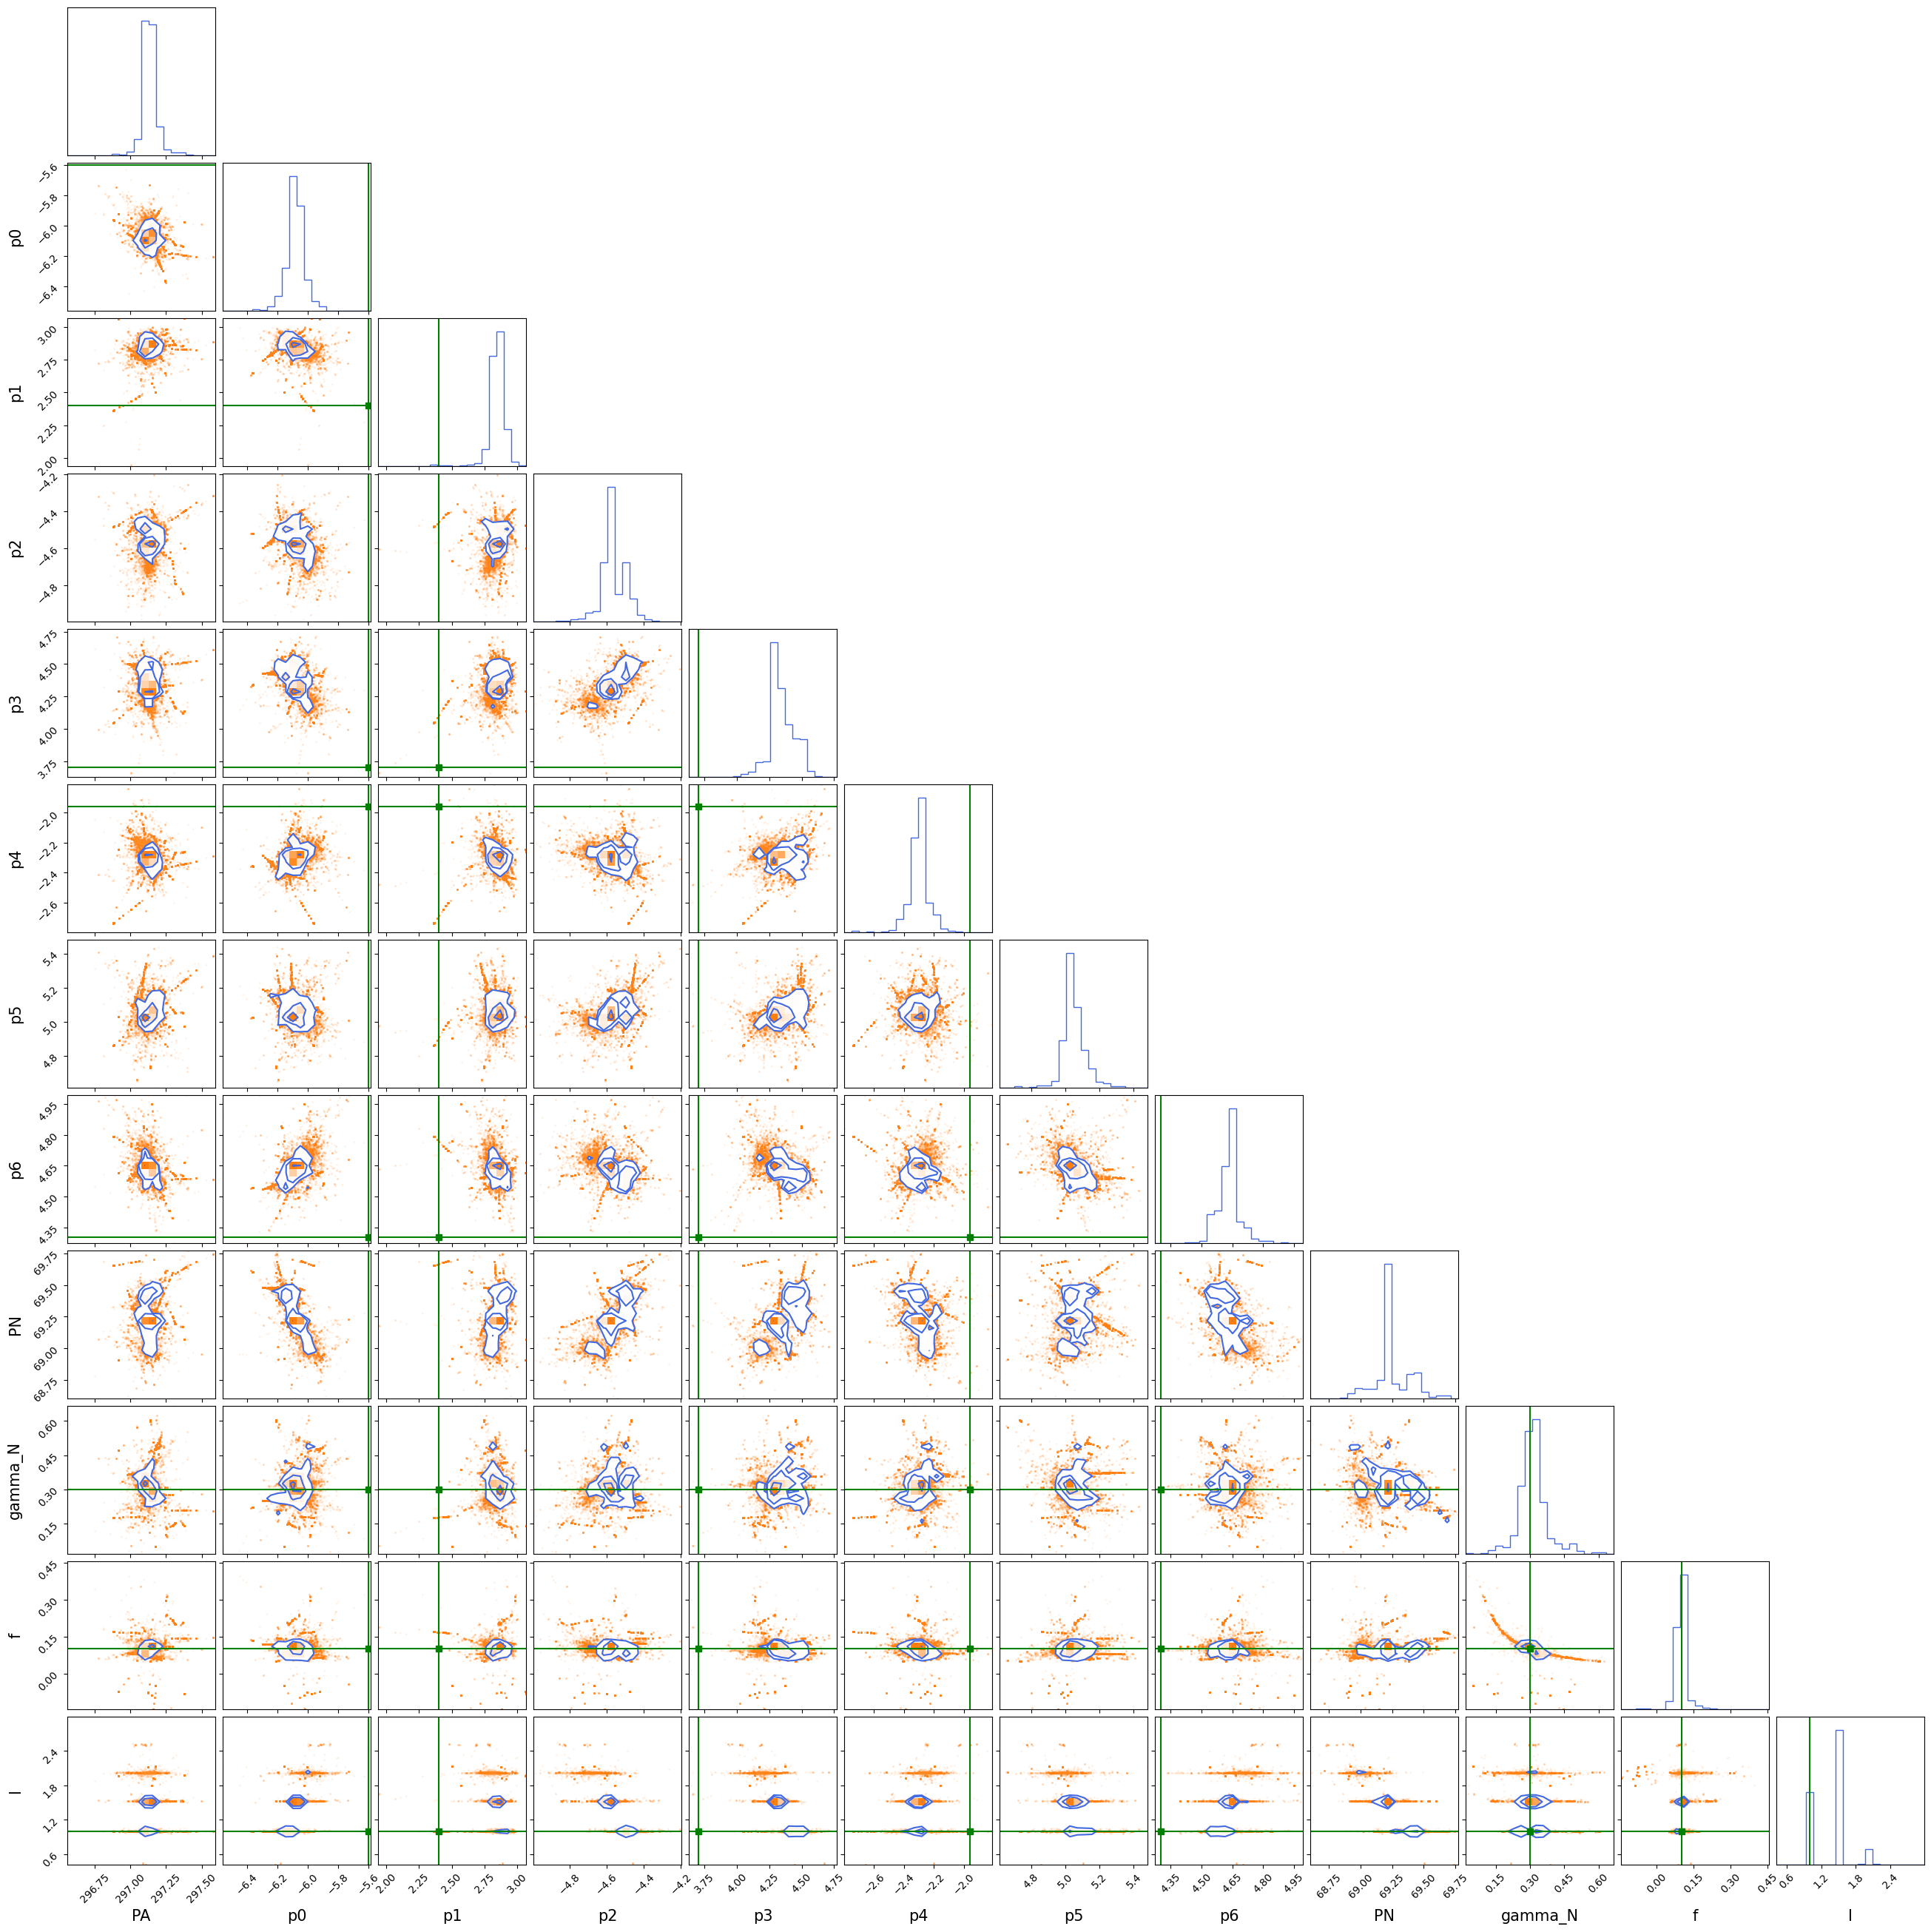

Best-fit parameters (Maximum Likelihood Estimate): [297.0955026668041, -6.155604597205871, 2.90335254435913, -4.494549937582053, 4.4086987354653075, -2.2907853368552953, 5.039588937431848, 4.541738670390969, 69.42710067539687, 0.32121747156862285, 0.09377921666939262, 0.9999999997496835]


In [18]:
parameter_names = ["PA", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "PN", "gamma_N", "f","l"]
#corner plot 
fig = corner.corner(samples, labels=parameter_names, truths=ip_params, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
label_kwargs={"fontsize":15}, #set label size
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
#plt.savefig('/Document/gopipatel/Desktop/RLC_full_BH_1m.png', dpi=300)
plt.show()

#print("Expected Paramerters:",ip_params)
print("Best-fit parameters (Maximum Likelihood Estimate):", best_fit_params)

In [19]:
#PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = best_fit_params
Ta=Compute_Tmeas_(*best_fit_params)
ip_params=[300,-6.33,  2.67, -4.56,  4.2, -2.2,  5.1,  4.7, 70, 0.3, 0.1, 1]
TA=Compute_Tmeas_(*ip_params)
plt.plot(,Ta,label='Observed', color='C1',alpha=0.3, lw=6)
plt.plot(v,TA,label='Expected', color='brown')
plt.legend()
plt.title('TA vs Freq for RLC')
plt.savefig('/Users/gopipatel/Desktop/Comparision_plot_2m.png', dpi=300)

NameError: name 'v' is not defined